In [1]:
from fuzzy_art import *
import sklearn.datasets as ds
import sklearn.decomposition as dcp
import matplotlib.pyplot as plt

In [2]:
iris = ds.load_iris()
data = iris['data'] / np.max(iris['data'], axis=0)
label_true = iris['target']
# pca
pca = dcp.PCA(n_components=2)
pca_xy = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.92138578 0.05142129]
[4.9602239  1.17179601]


0.0
0.25
0.5
0.75
1.0


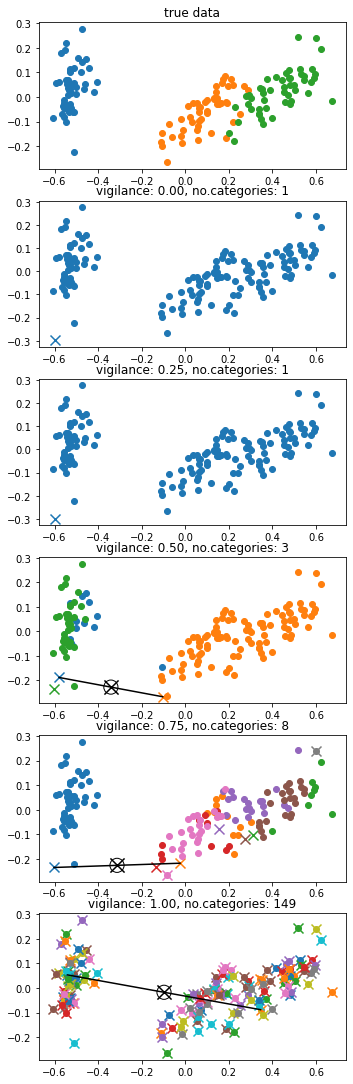

In [23]:
no_rho = 5
ls_rho = np.linspace(0, 1, no_rho)
fig, axs = plt.subplots(no_rho + 1, 1,
                        figsize = (5, ls_rho.size * 3))
fig.tight_layout()

# plot true
for cat_true in range(3):
    axs[0].scatter(*np.where(label_true == cat_true, pca_xy.T, None))
axs[0].set_title('true data')

# use FuzzyART
for rho, ax in zip(ls_rho, axs[1:]): 
    print(rho)
    # init
    net = FuzzyART(alpha=0.5, rho=rho)
    
    # train
    net.train(data, epochs=100) # each epoch, all data is shuffled
    label_pred = net.test(data).astype(int)

    # plot 
    cat_number = net.w.shape[0]
    cat_centre = pca.transform(net.w[:, :4])
    for cat_pred, cat_x, cat_y in zip(range(cat_number), *cat_centre.T):
        c = next(ax._get_lines.prop_cycler)['color']
        ax.scatter(*np.where(label_pred == cat_pred, pca_xy.T, None), color = c) # all training samples
        ax.scatter(cat_x, cat_y, marker = 'x', s = 100, color = c) # categorical centre
    ax.set_title('vigilance: {:.2f}, no.categories: {}'.format(rho, cat_number))
    
    if 1 < cat_number:
        # interplot 2 cats
        inter01 = pca.transform([np.mean(net.w[:2, :4], axis = 0)])
        ax.scatter(*inter01.T, marker = 'o', s = 200, edgecolors = 'k', facecolors='none')
        interpca01 = np.mean(cat_centre[:2], axis = 0)
        ax.scatter(*interpca01.T, marker = 'x', s = 200, c = 'k')
        ax.plot(*cat_centre[:2].T, c = 'k')